In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Input, Multiply, Activation
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/PM2.5_aeroequal_and_council.csv')
data.head()

,Datetime,PM2.5_mg/m³_aeroequal,PM2.5_µg/m³_council
0,2024-08-15 15:00:00,0.566667,4.8
1,2024-08-15 16:00:00,0.733333,3.8
2,2024-08-15 17:00:00,0.633333,7.1
3,2024-08-15 18:00:00,0.566667,6.4
4,2024-08-16 11:00:00,0.777778,3.8


In [3]:
X = data[['PM2.5_mg/m³_aeroequal']].values
y = data['PM2.5_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[0.9       ],
       [1.83928571],
       [0.83333333],
       [2.91666667],
       [0.28333333]])

array([[ 0.36321468],
       [ 2.05730277],
       [ 0.24297522],
       [ 4.00045831],
       [-0.74900031]])

array([[0.73333333],
       [1.2       ],
       [0.21212121],
       [0.66666667],
       [0.77777778]])

array([[ 0.06261604],
       [ 0.90429225],
       [-0.87743791],
       [-0.05762342],
       [ 0.14277567]])

In [7]:
def build_keras_model(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [8]:
def build_rnn_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(SimpleRNN(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [9]:
def build_gru_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(GRU(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(GRU(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [10]:
def build_lstm_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()

    for i in range(layers):
        if i == 0:
            model.add(LSTM(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(LSTM(units[i], return_sequences=False))
    
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [11]:
def build_keras_model_with_attention(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    
    attention = Dense(1, activation='tanh')(model.layers[-1].output)
    attention = Activation('softmax')(attention)
    attention = Multiply()([model.layers[-1].output, attention])
    
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [12]:
def build_rnn_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    rnn_out = inputs
    for i in range(layers):
        rnn_out = SimpleRNN(units[i], return_sequences=True if layers > 1 else False)(rnn_out)
    
    attention = Dense(1, activation='tanh')(rnn_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([rnn_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [13]:
def build_gru_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    gru_out = inputs
    for i in range(layers):
        gru_out = GRU(units[i], return_sequences=True if layers > 1 else False)(gru_out)
    
    attention = Dense(1, activation='tanh')(gru_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([gru_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [14]:
def build_lstm_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    lstm_out = inputs
    
    for i in range(layers):
        lstm_out = LSTM(units[i], return_sequences=True if layers > 1 else False)(lstm_out)
    
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([lstm_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

## Experimented List of Models and Parameters

#### The MLPRegressor: This model optimizes the squared error using LBFGS or stochastic gradient descent.
#### The KerasRegressor: Wrapper that enables Keras models so that they can be used as part of a Scikit-Learn workflow

In [15]:
models = {
    'MLP Regressor': MLPRegressor(random_state=42, verbose=0),
    'Keras Regressor': KerasRegressor(build_fn=build_keras_model, verbose=0),
    'RNN Regressor': KerasRegressor(build_fn=build_rnn_model, verbose=0),
    'GRU Regressor': KerasRegressor(build_fn=build_gru_model, verbose=0),
    'LSTM Regressor': KerasRegressor(build_fn=build_lstm_model, verbose=0),
    'MLP Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'Keras Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'RNN Regressor with Attention': KerasRegressor(build_fn=build_rnn_model_with_attention, verbose=0),
    'GRU Regressor with Attention': KerasRegressor(build_fn=build_gru_model_with_attention, verbose=0),
    'LSTM Regressor with Attention': KerasRegressor(build_fn=build_lstm_model_with_attention, verbose=0),
}

params = {
    'MLP Regressor': {
        'hidden_layer_sizes': [(50, 50), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [200, 400],
    },
    'Keras Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'MLP Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'Keras Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    }
}

#### 1. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 2. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [16]:
best_models = []

best_score = float('inf')
best_params = None
best_model_name = ''

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    grid = GridSearchCV(estimator=model, param_grid=params[model_name], n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
    grid_result = grid.fit(X_train_scaled, y_train)
    
    try:
        best_models.append({
            'name': model_name,
            'model': grid_result.best_estimator_,
            'params': grid_result.best_params_,
            'rmse': -grid_result.best_score_
        })
    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training MLP Regressor...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Training Keras Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training MLP Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training Keras Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


#### For showcasing model with the best R2

In [17]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled) 
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

In [18]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: GRU Regressor
Best Hyperparameters: {'batch_size': 20, 'epochs': 50, 'optimizer': 'rmsprop'}
Test RMSE: 1.9263
Test MSE: 3.7106
Test R2: 0.4867
Test MAE: 1.5189


,Actual,Predicted
0,6.3,5.816908
1,5.0,7.673528
2,4.3,3.870812
3,4.4,5.557289
4,3.8,5.991196
5,6.3,3.427892
6,4.0,4.243038
7,5.9,5.686810
8,6.3,6.540768
9,7.4,4.732514


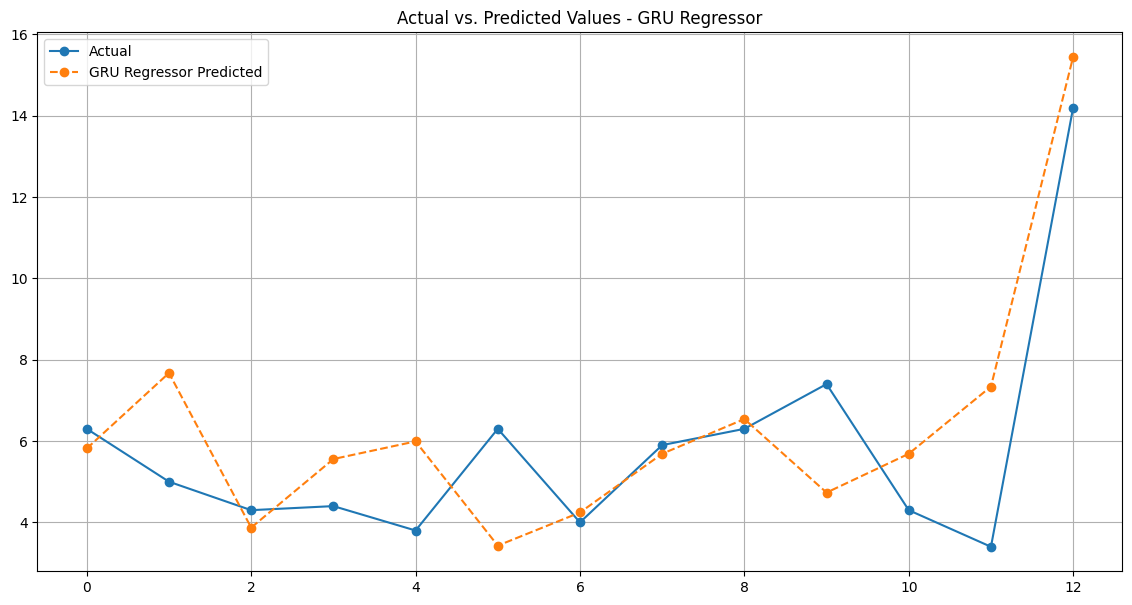


Results For Model: LSTM Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 50, 'optimizer': 'rmsprop'}
Test RMSE: 2.0482
Test MSE: 4.1951
Test R2: 0.4197
Test MAE: 1.6349


,Actual,Predicted
0,6.3,5.918745
1,5.0,7.823638
2,4.3,4.037827
3,4.4,5.660800
4,3.8,6.093092
5,6.3,3.627121
6,4.0,4.388054
7,5.9,5.789221
8,6.3,6.649005
9,7.4,4.855549


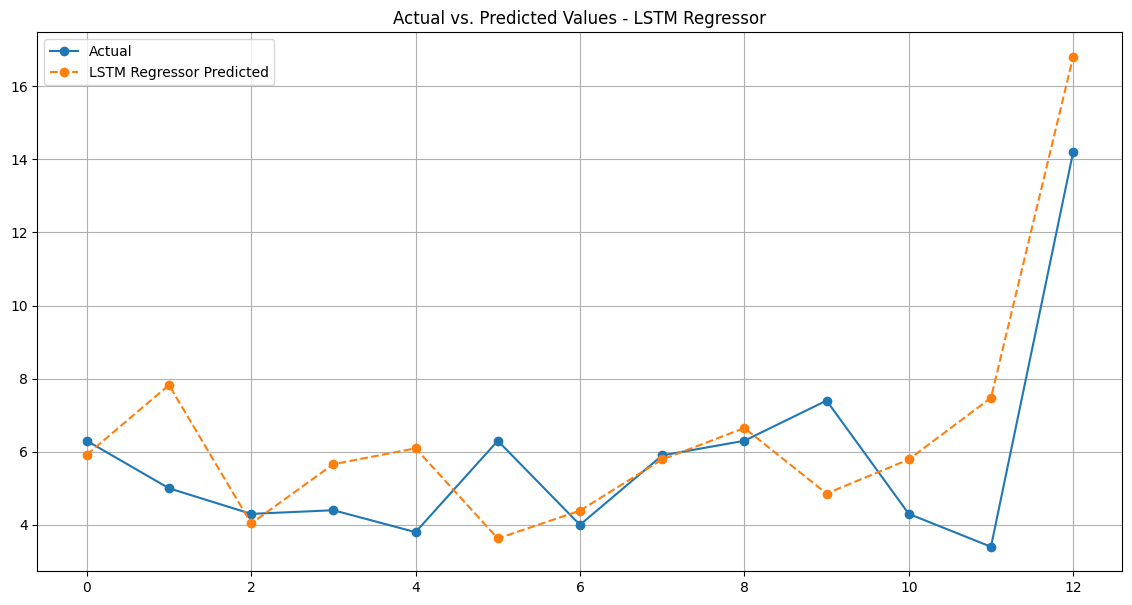


Results For Model: LSTM Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 2.0748
Test MSE: 4.3048
Test R2: 0.4045
Test MAE: 1.5401


,Actual,Predicted
0,6.3,5.639362
1,5.0,5.585117
2,4.3,6.026782
3,4.4,5.670508
4,3.8,5.621795
5,6.3,6.168545
6,4.0,5.923986
7,5.9,5.654220
8,6.3,5.583630
9,7.4,5.810263


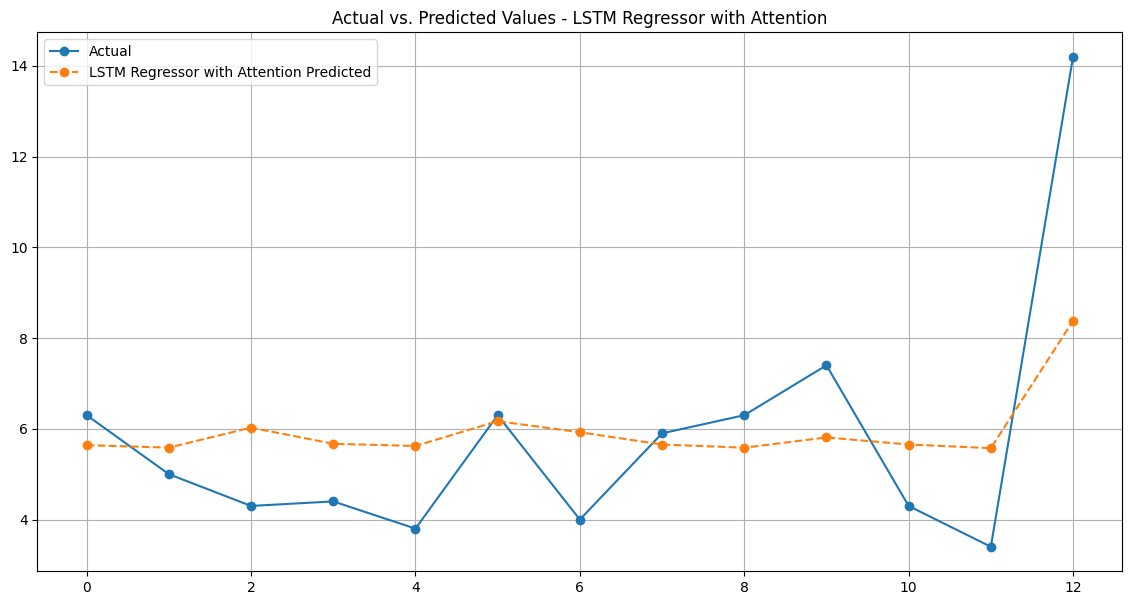


Results For Model: RNN Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 50, 'optimizer': 'adam'}
Test RMSE: 2.2152
Test MSE: 4.9069
Test R2: 0.3212
Test MAE: 1.7343


,Actual,Predicted
0,6.3,6.239649
1,5.0,8.275360
2,4.3,3.615779
3,4.4,5.925590
4,3.8,6.445553
5,6.3,2.913126
6,4.0,4.172067
7,5.9,6.083408
8,6.3,7.071803
9,7.4,4.860647


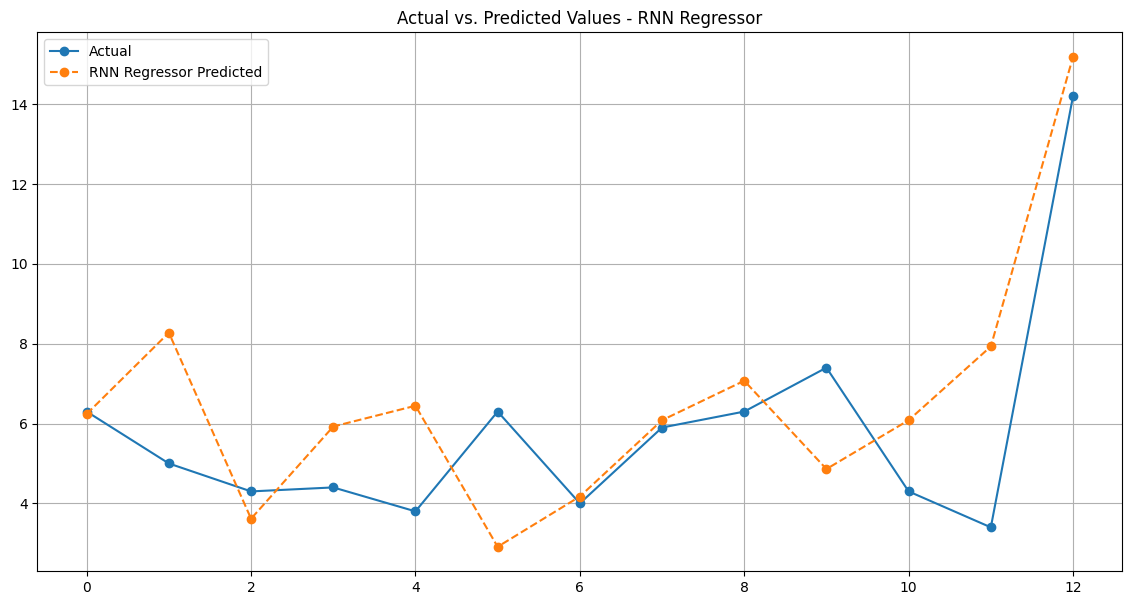


Results For Model: MLP Regressor
Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'sgd'}
Test RMSE: 2.2260
Test MSE: 4.9552
Test R2: 0.3145
Test MAE: 1.6976


,Actual,Predicted
0,6.3,6.143292
1,5.0,8.327298
2,4.3,3.458328
3,4.4,5.810886
4,3.8,6.362451
5,6.3,2.776894
6,4.0,4.008925
7,5.9,5.977621
8,6.3,7.033428
9,7.4,4.704665


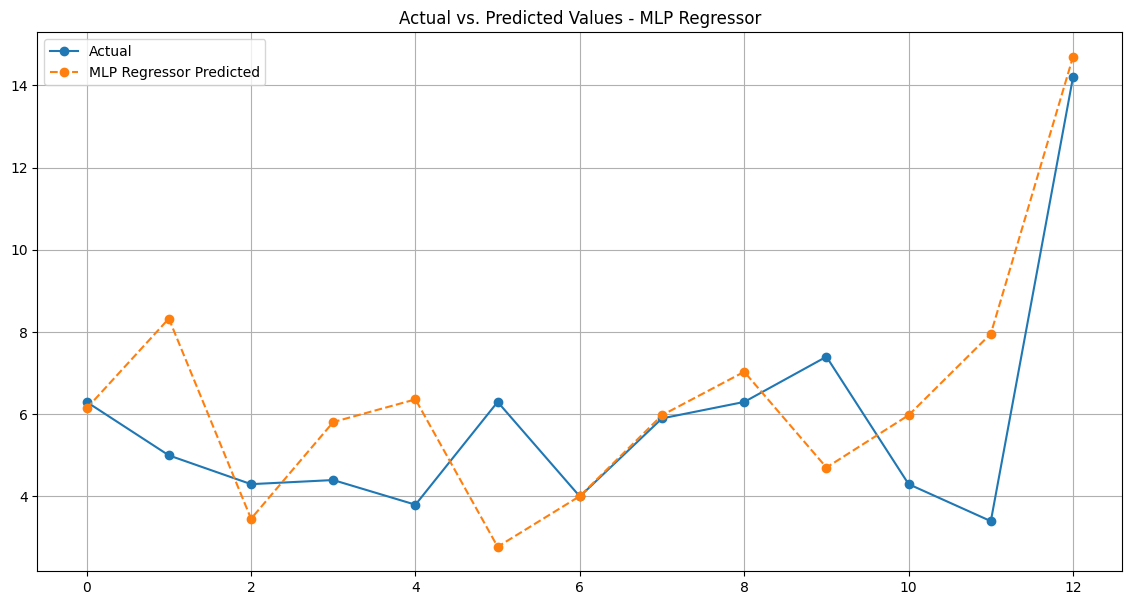


Results For Model: Keras Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 2.3345
Test MSE: 5.4497
Test R2: 0.2461
Test MAE: 1.6748


,Actual,Predicted
0,6.3,4.595922
1,5.0,6.992688
2,4.3,4.994598
3,4.4,4.412008
4,3.8,4.783723
5,6.3,5.421467
6,4.0,4.765221
7,5.9,4.536527
8,6.3,5.541969
9,7.4,4.520237


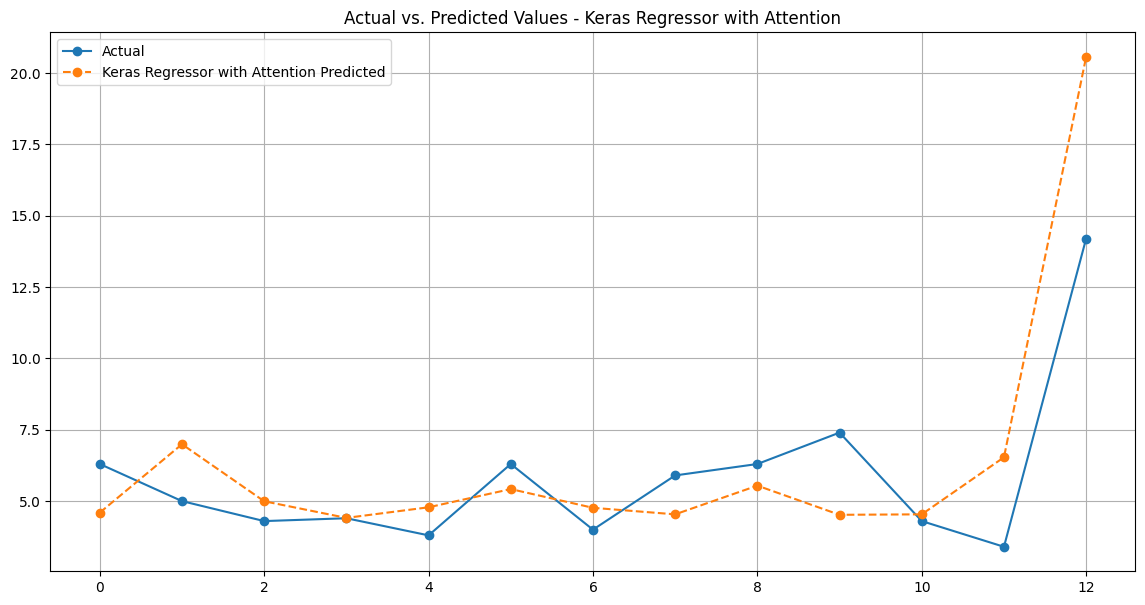


Results For Model: GRU Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 2.5463
Test MSE: 6.4835
Test R2: 0.1031
Test MAE: 1.7263


,Actual,Predicted
0,6.3,5.825420
1,5.0,5.850118
2,4.3,5.852948
3,4.4,5.825452
4,3.8,5.825925
5,6.3,5.870021
6,4.0,5.842200
7,5.9,5.825316
8,6.3,5.830121
9,7.4,5.832417


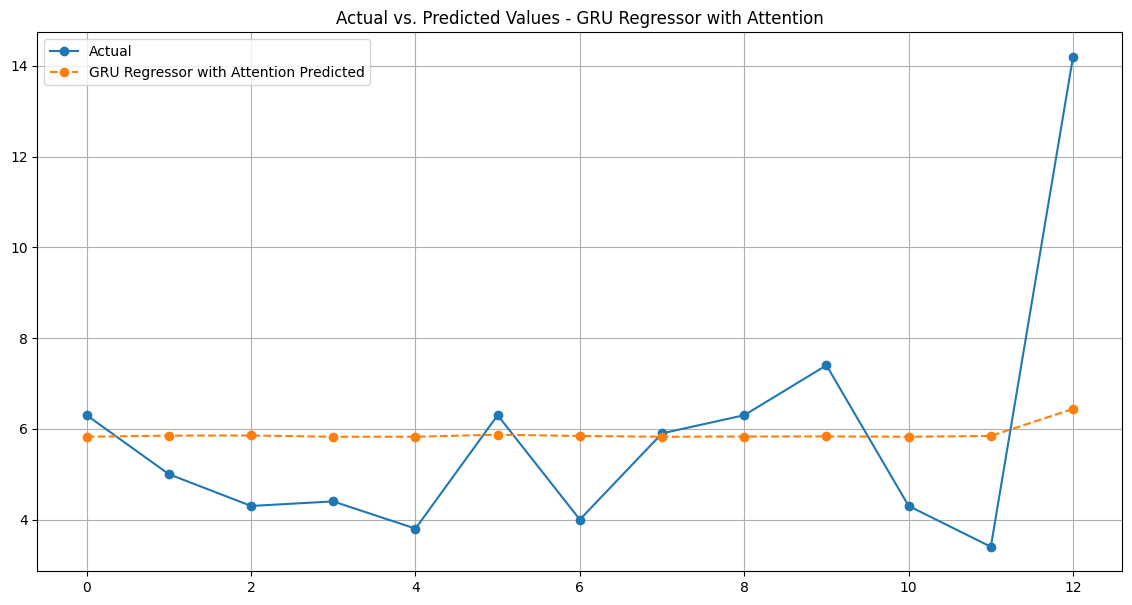


Results For Model: MLP Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 2.5480
Test MSE: 6.4924
Test R2: 0.1019
Test MAE: 1.8716


,Actual,Predicted
0,6.3,3.733358
1,5.0,6.158485
2,4.3,5.720287
3,4.4,3.533427
4,3.8,3.940891
5,6.3,6.519495
6,4.0,5.115480
7,5.9,3.623578
8,6.3,4.819600
9,7.4,4.386114


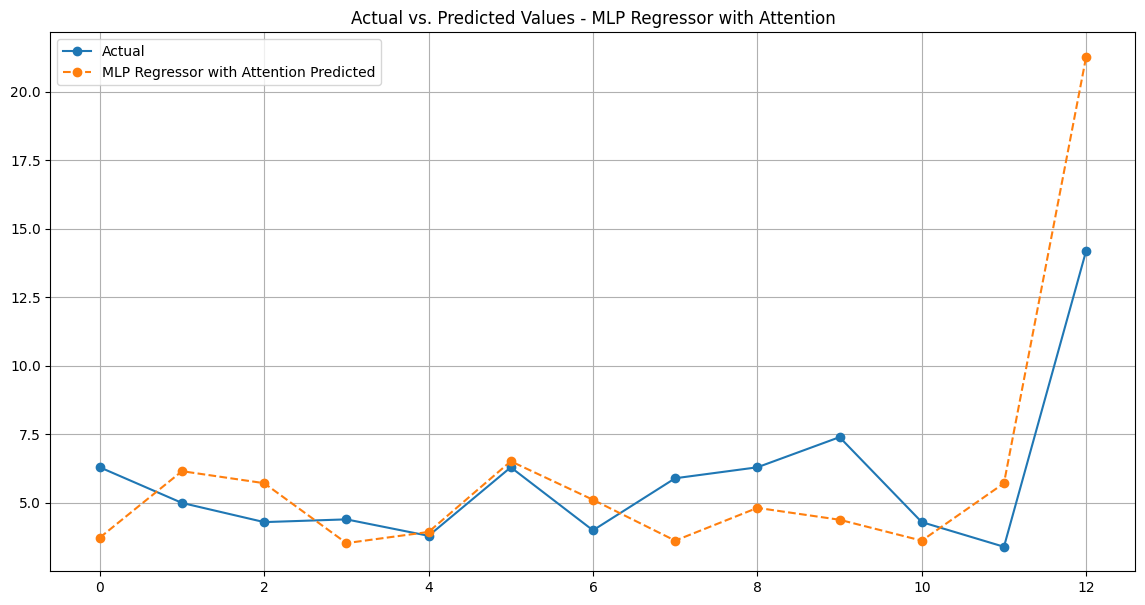


Results For Model: RNN Regressor with Attention
Best Hyperparameters: {'batch_size': 20, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 2.8754
Test MSE: 8.2678
Test R2: -0.1437
Test MAE: 1.8624


,Actual,Predicted
0,6.3,6.032482
1,5.0,5.951201
2,4.3,5.357595
3,4.4,5.993273
4,3.8,6.050344
5,6.3,5.086198
6,4.0,5.553631
7,5.9,6.014752
8,6.3,6.065629
9,7.4,5.764396


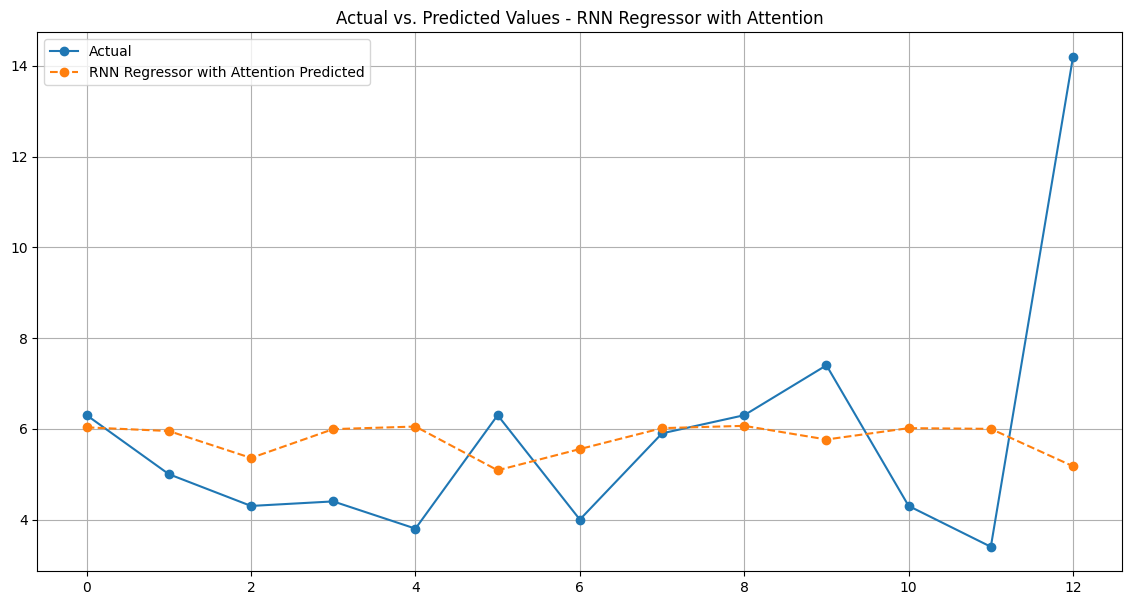


Results For Model: Keras Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 3.0351
Test MSE: 9.2120
Test R2: -0.2743
Test MAE: 2.3789


,Actual,Predicted
0,6.3,2.900623
1,5.0,6.128267
2,4.3,6.185182
3,4.4,2.904827
4,3.8,3.154186
5,6.3,7.287236
6,4.0,5.305418
7,5.9,2.896145
8,6.3,4.246301
9,7.4,4.200197


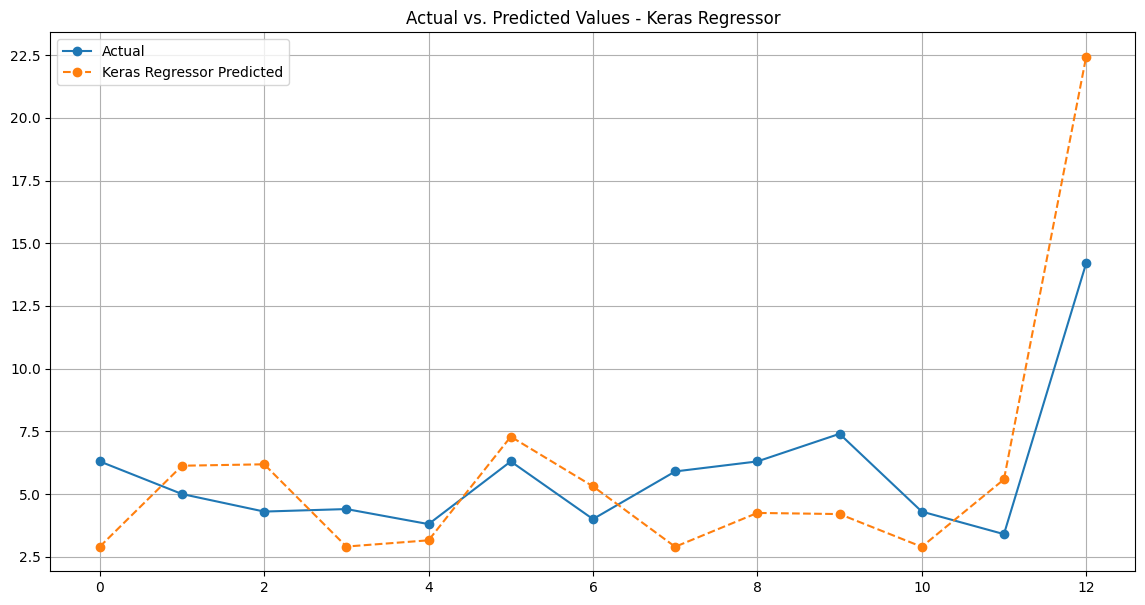

In [19]:
for result in results:
    model_name = result['name']
    print(f"Results For Model: {model_name}")
    print(f"Best Hyperparameters: {result['params']}")
    print(f"Test RMSE: {result['rmse']:.4f}")
    print(f"Test MSE: {result['mse']:.4f}")
    print(f"Test R2: {result['r2']:.4f}")
    print(f"Test MAE: {result['mae']:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [20]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,GRU Regressor,1.926281,3.710559,0.486712,1.518915
1,LSTM Regressor,2.048203,4.195137,0.419679,1.634924
2,LSTM Regressor with Attention,2.074801,4.304799,0.404509,1.540121
3,RNN Regressor,2.215159,4.906930,0.321215,1.734340
4,MLP Regressor,2.226021,4.955169,0.314542,1.697566
5,Keras Regressor with Attention,2.334459,5.449699,0.246133,1.674768
6,GRU Regressor with Attention,2.546277,6.483528,0.103122,1.726343
7,MLP Regressor with Attention,2.548019,6.492403,0.101894,1.871633
8,RNN Regressor with Attention,2.875370,8.267753,-0.143693,1.862413
9,Keras Regressor,3.035130,9.212014,-0.274315,2.378928
